### Bussiness Goal:
A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.

The company is looking at prospective properties to buy to enter the market. To achieve this, they would need a machine learning model to understand how exactly the prices vary with the variables. They can accordingly manipulate the strategy of the firm and concentrate on areas that will yield high returns. Further, the model will be a good way for management to understand the pricing dynamics of a new market.

Steps to build the required model:
- Understand and clean the dataset: EDA.
- Build Ridge Regression model using GridsearchCV for hyperparameter tuning
- Build Lasso Regression model using GridsearchCV for hyperparameter tuning


#### Import required libraries

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import statsmodels.api as sm

In [113]:
from sklearn.feature_selection import RFE

#### Exploratory Data analysis
This section includes cleanup, data prep and analysis to determine which variables suit best to build our model

In [72]:
# Read the data from csv file
df = pd.read_csv('train.csv')

In [73]:
# Drop columns with more than 40% null values
null_percentages = 100*df.isnull().mean()
columns_with_high_nulls = null_percentages[null_percentages > 40].index.tolist()
df = df.drop(columns=columns_with_high_nulls, axis=1)

In [74]:
# check to see if there are any columns with same value across all the rows to drop them
columns_with_one_unique_value = df.columns[df.nunique() == 1]
columns_with_one_unique_value

Index([], dtype='object')

In [75]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [77]:
df = df.drop('Id', axis = 1)

In [78]:
# Given the nature of the data where each numerical value corresponds to a 
# specific type of dwelling, converting it to a categorical variable and creating dummy variables 
# for each category can help the model interpret these classes correctly without assuming an 
# inherent numerical relationship between them.

df['MSSubClass'] = df['MSSubClass'].astype(object)

In [79]:
Null_cols = df.isnull().sum()
columns_with_nulls = Null_cols[Null_cols > 1]
columns_with_nulls

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

#### Data imputations

In [80]:
# Replacing null values with average LotFrontage values as per Neighborhood

neighborhood_lotfrontage_avg = df.groupby('Neighborhood')['LotFrontage'].transform('mean')
df['LotFrontage'] = df['LotFrontage'].fillna(neighborhood_lotfrontage_avg)

In [81]:
df['MasVnrType'] = df['MasVnrType'].fillna('None')
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [82]:
df['BsmtQual'] = df['BsmtQual'].fillna('NoBasement')
df['BsmtCond'] = df['BsmtCond'].fillna('NoBasement')
df['BsmtExposure'] = df['BsmtExposure'].fillna('NoBasement')
df['BsmtFinType1'] = df['BsmtFinType1'].fillna('NoBasement')
df['BsmtFinType2'] = df['BsmtFinType2'].fillna('NoBasement')

In [83]:
df['GarageType'] = df['GarageType'].fillna('NoGarage')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna('NoGarage')
df['GarageFinish'] = df['GarageFinish'].fillna('NoGarage')
df['GarageQual'] = df['GarageQual'].fillna('NoGarage')
df['GarageCond'] = df['GarageCond'].fillna('NoGarage')

In [84]:
Null_cols = df.isnull().sum()
columns_with_nulls = Null_cols[Null_cols > 1]
columns_with_nulls

Series([], dtype: int64)

In [85]:
df['CentralAir'] = df['CentralAir'].map({'N': 0, 'Y': 1})

In [86]:
df_categorical = df.select_dtypes(include=['object'])
df_numerical = df.select_dtypes(include=['int64', 'float64'])

In [87]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 39 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   object
 1   MSZoning       1460 non-null   object
 2   Street         1460 non-null   object
 3   LotShape       1460 non-null   object
 4   LandContour    1460 non-null   object
 5   Utilities      1460 non-null   object
 6   LotConfig      1460 non-null   object
 7   LandSlope      1460 non-null   object
 8   Neighborhood   1460 non-null   object
 9   Condition1     1460 non-null   object
 10  Condition2     1460 non-null   object
 11  BldgType       1460 non-null   object
 12  HouseStyle     1460 non-null   object
 13  RoofStyle      1460 non-null   object
 14  RoofMatl       1460 non-null   object
 15  Exterior1st    1460 non-null   object
 16  Exterior2nd    1460 non-null   object
 17  MasVnrType     1460 non-null   object
 18  ExterQual      1460 non-null

In [88]:
df_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotFrontage    1460 non-null   float64
 1   LotArea        1460 non-null   int64  
 2   OverallQual    1460 non-null   int64  
 3   OverallCond    1460 non-null   int64  
 4   YearBuilt      1460 non-null   int64  
 5   YearRemodAdd   1460 non-null   int64  
 6   MasVnrArea     1460 non-null   float64
 7   BsmtFinSF1     1460 non-null   int64  
 8   BsmtFinSF2     1460 non-null   int64  
 9   BsmtUnfSF      1460 non-null   int64  
 10  TotalBsmtSF    1460 non-null   int64  
 11  CentralAir     1460 non-null   int64  
 12  1stFlrSF       1460 non-null   int64  
 13  2ndFlrSF       1460 non-null   int64  
 14  LowQualFinSF   1460 non-null   int64  
 15  GrLivArea      1460 non-null   int64  
 16  BsmtFullBath   1460 non-null   int64  
 17  BsmtHalfBath   1460 non-null   int64  
 18  FullBath

In [60]:
# correlation matrix
cor = df_numerical.corr()


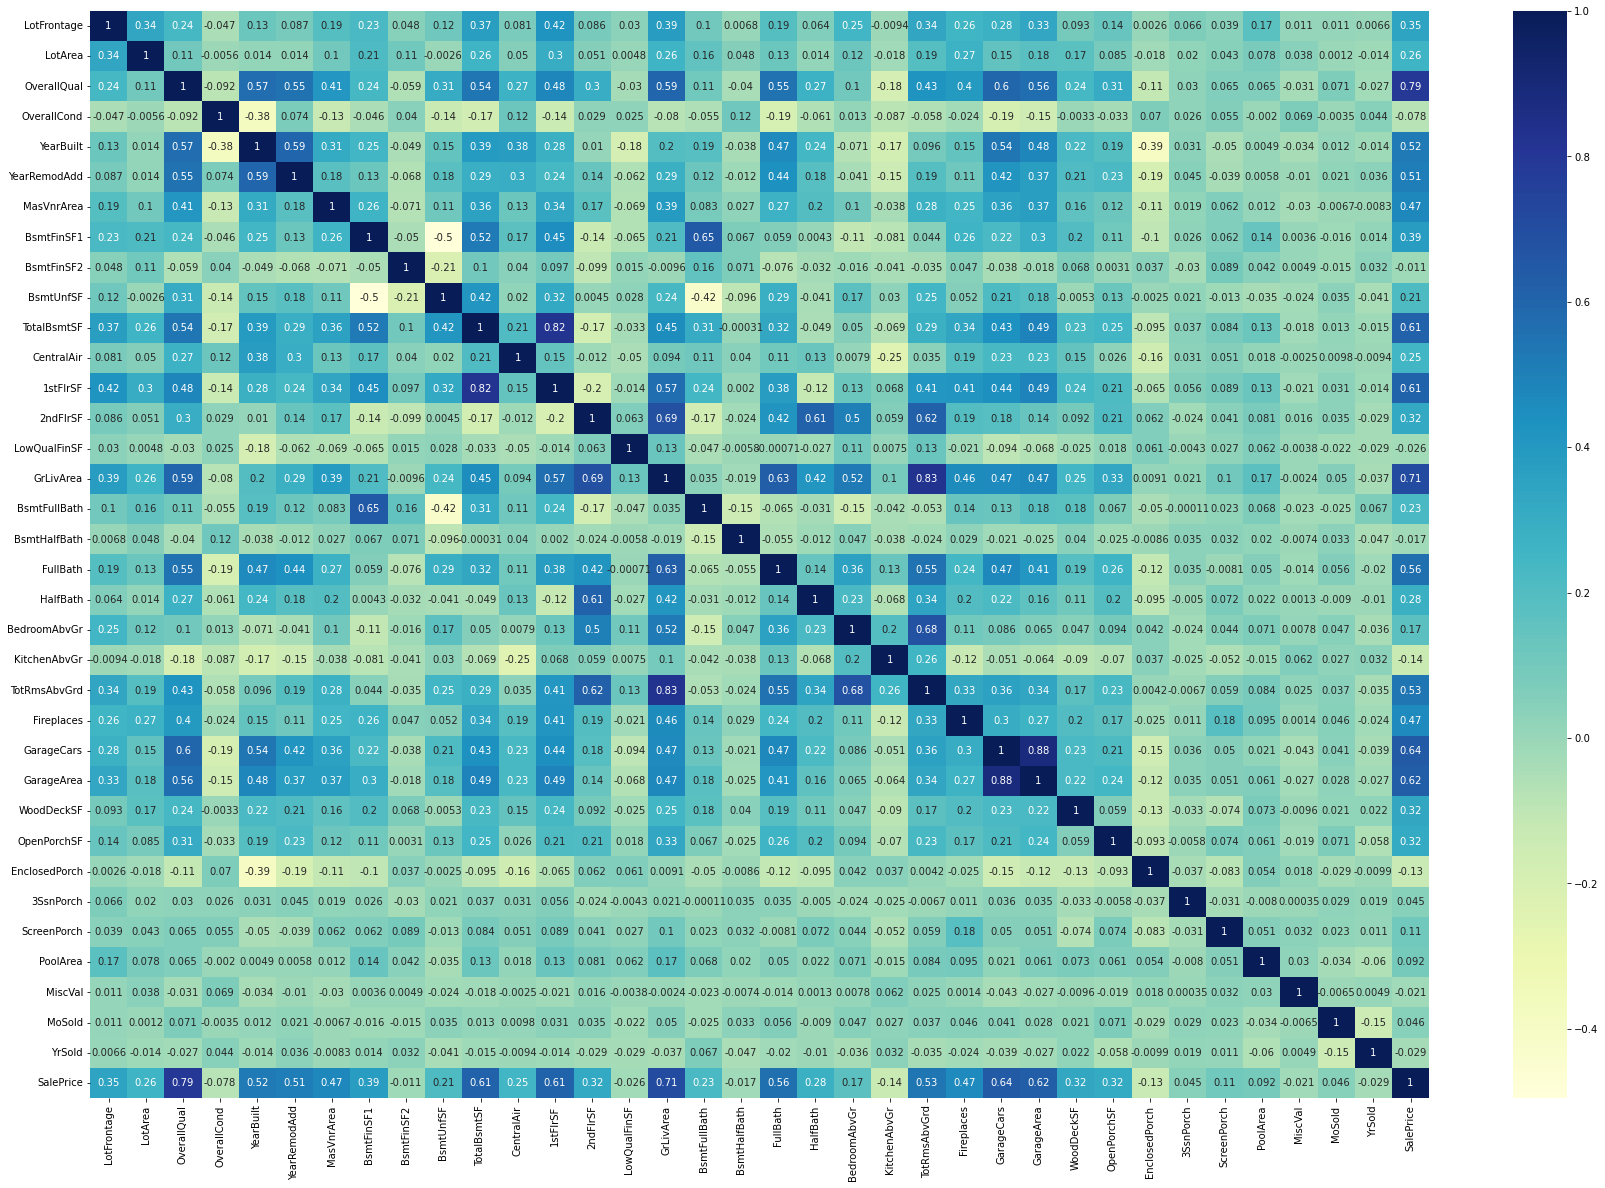

In [62]:
# plotting correlations on a heatmap
# figure size
plt.figure(figsize=(30,20))

# heatmap
sns.heatmap(cor, cmap="YlGnBu", annot=True)
plt.show()

Inferences from correlation matrix:
- SalePrice is highly correlated in a positive way with OverallQual, TotalBsmtSf, 1stFlrSF, GrLivArea, GarageCars, GarageArea. 
- SalePrice is negatively correlated with KitchenAbvGr and EnclosedPorch.
- There exists multi collinearity between the numerical variables as well 

In [89]:
cat_cols = df_categorical.columns

In [90]:
cat_cols

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [115]:
num_cols = df_numerical.columns
num_cols

Index(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

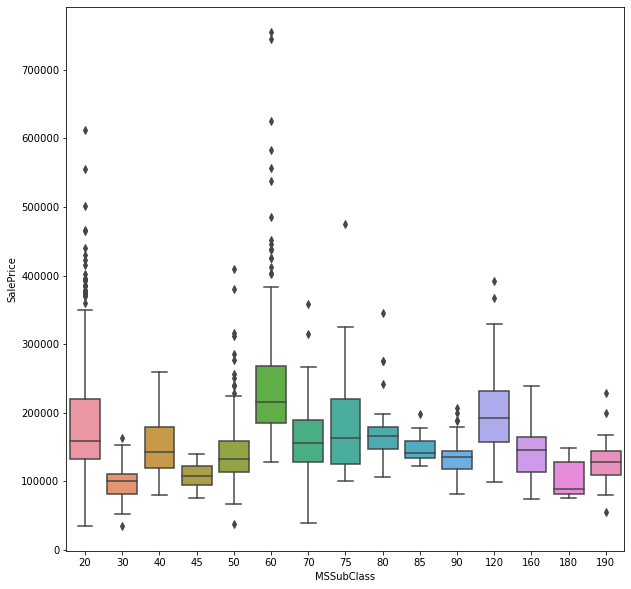

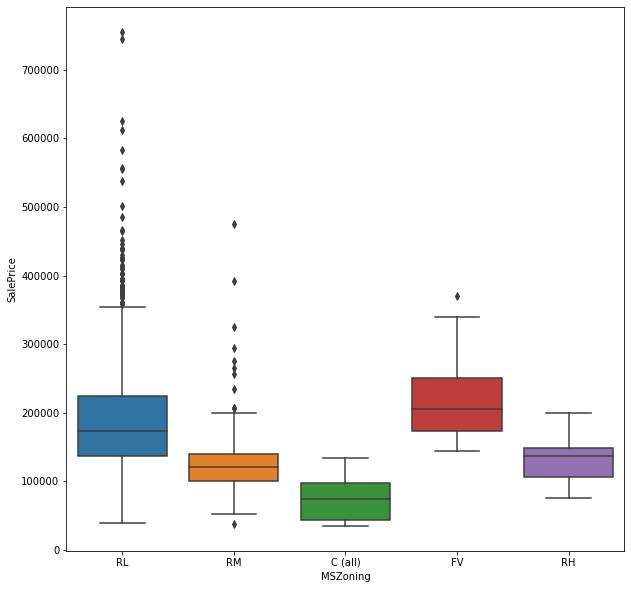

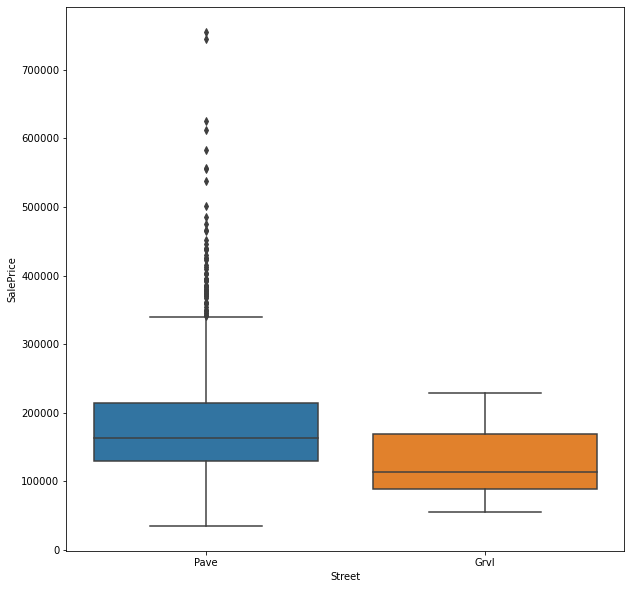

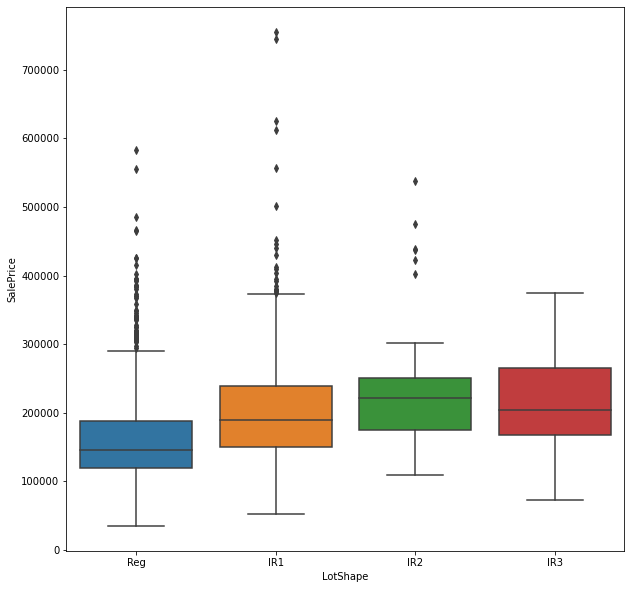

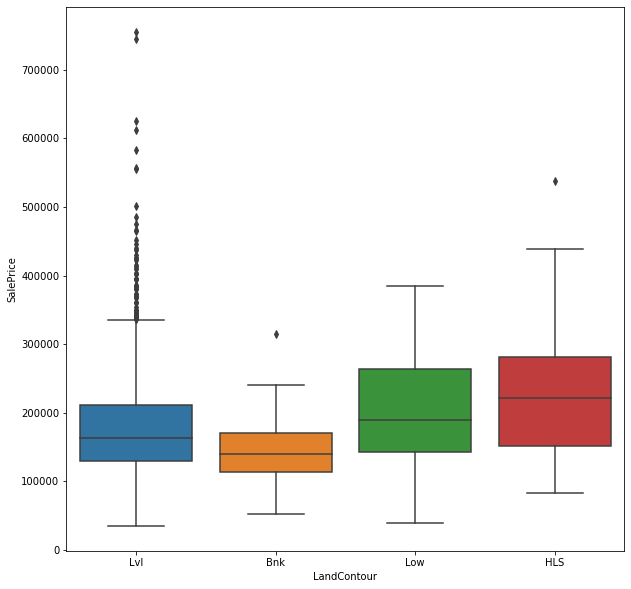

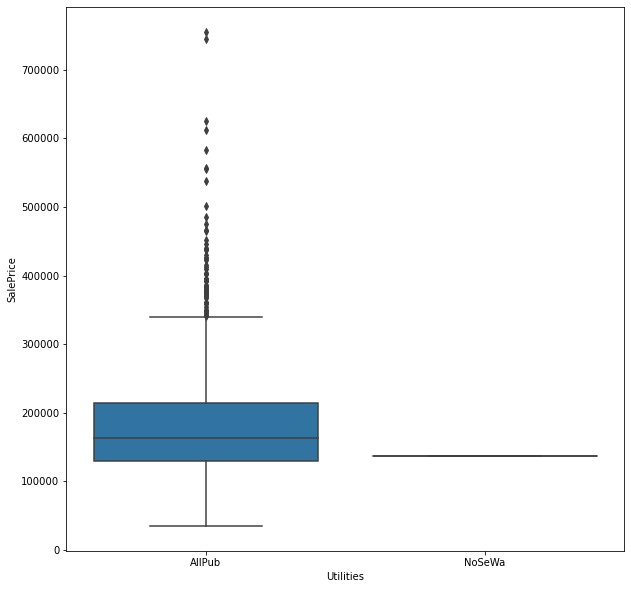

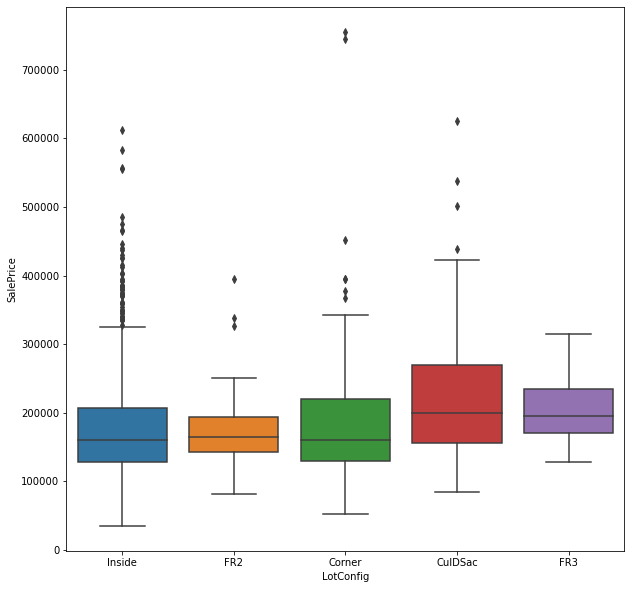

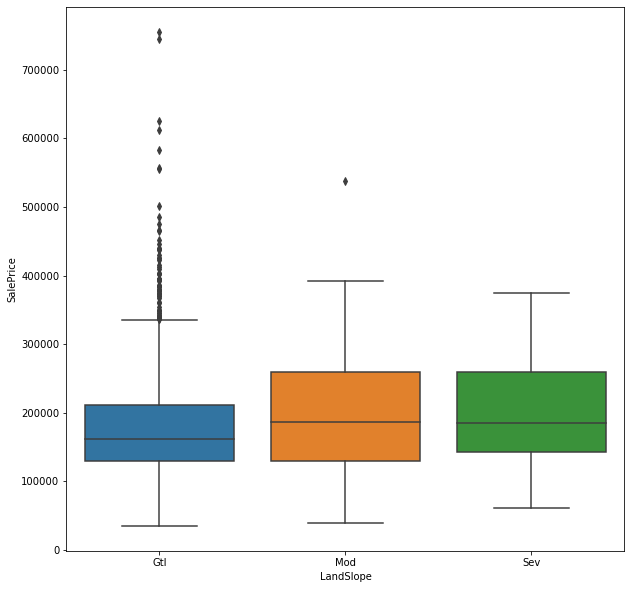

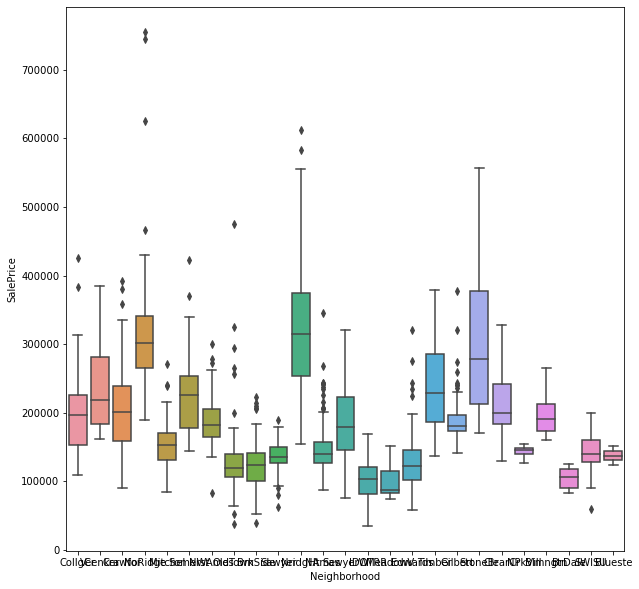

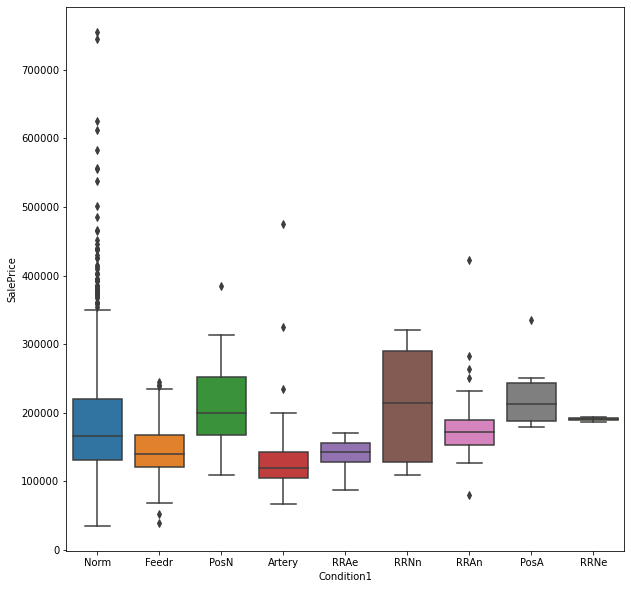

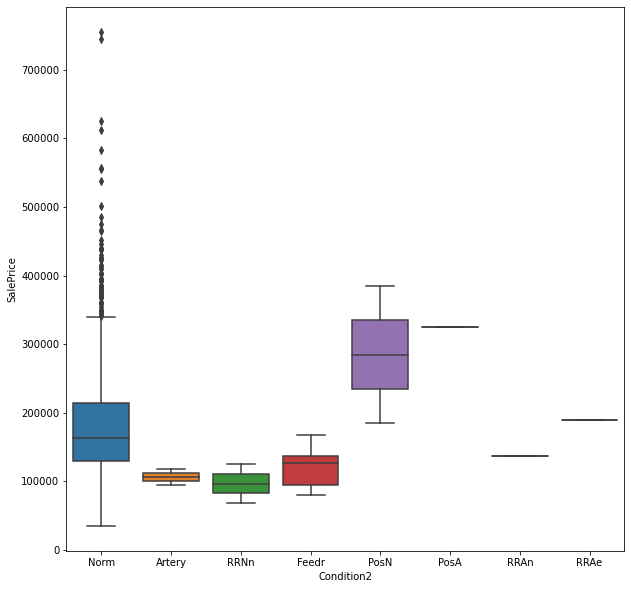

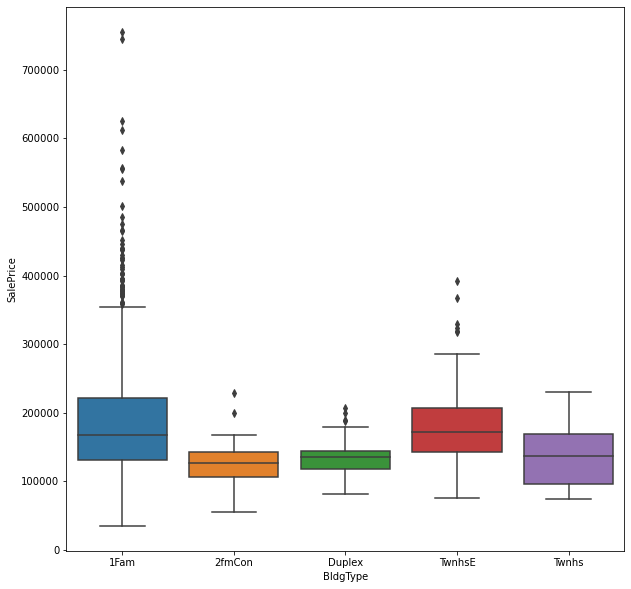

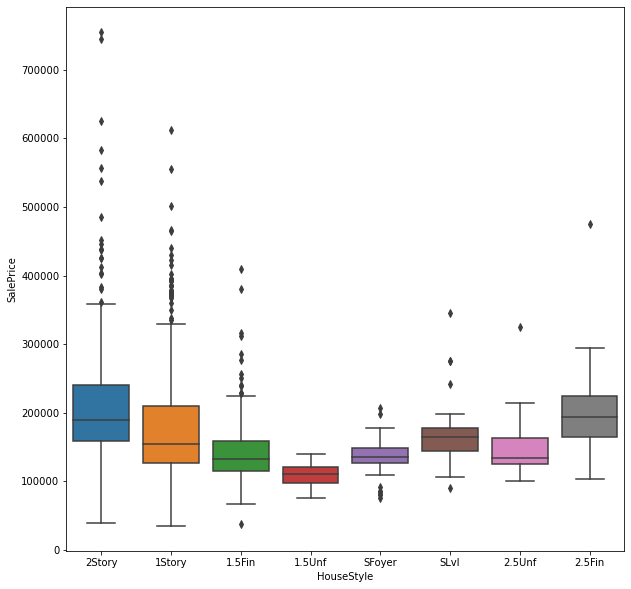

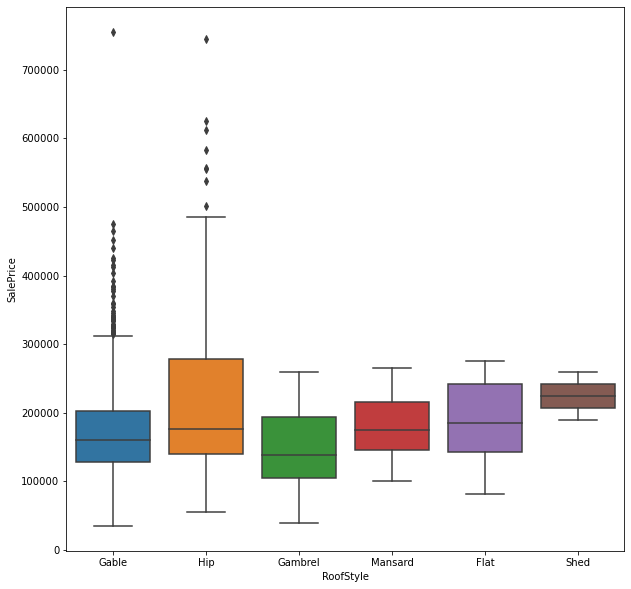

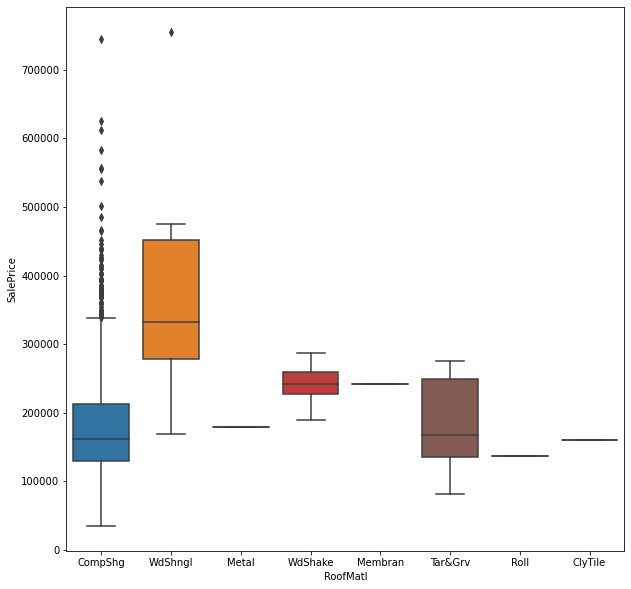

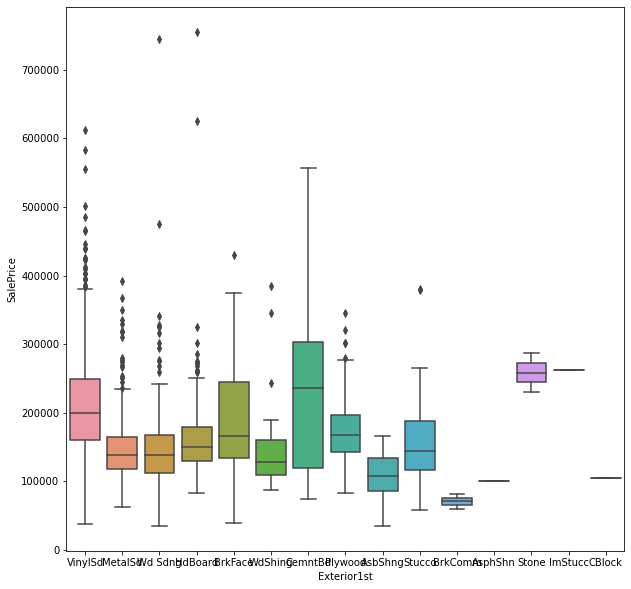

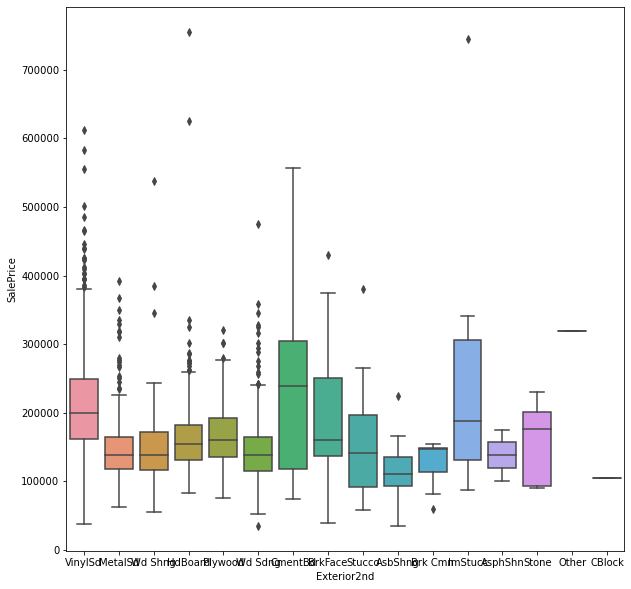

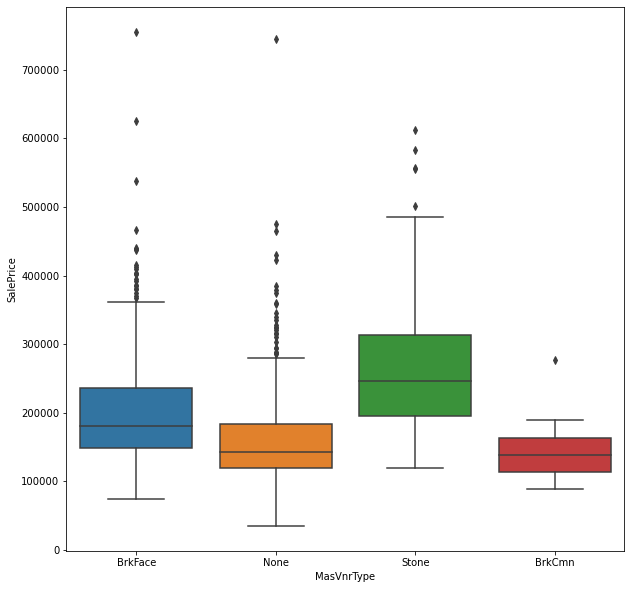

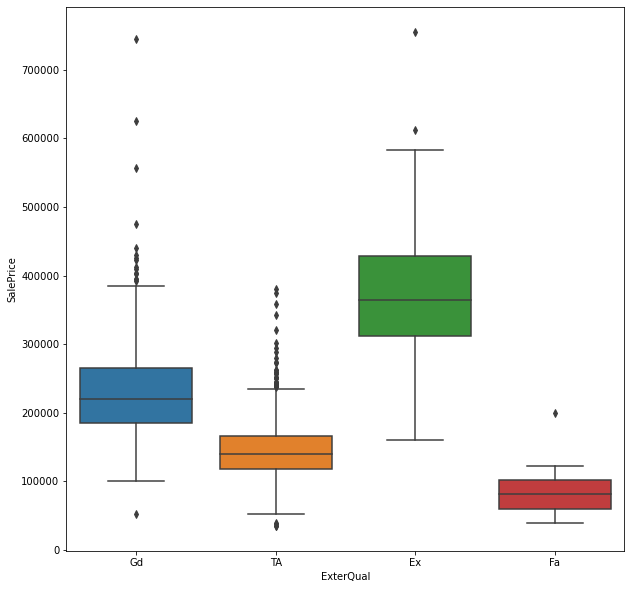

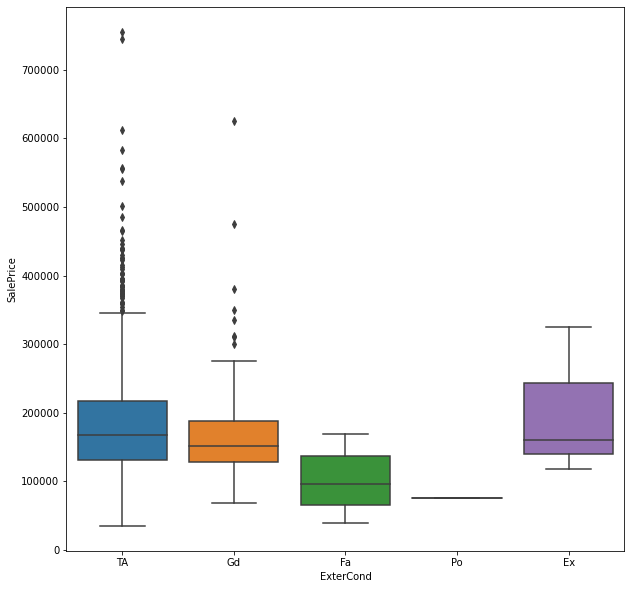

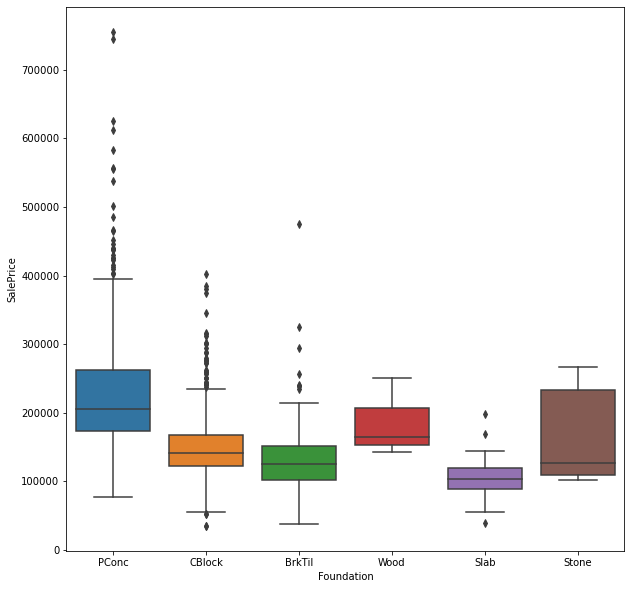

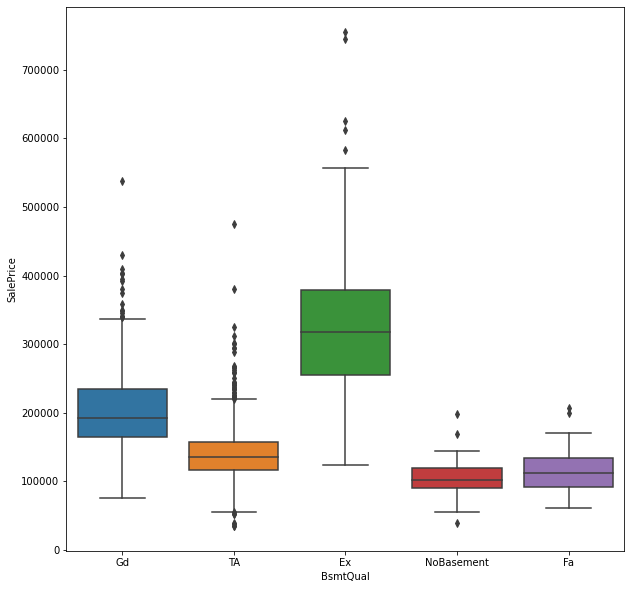

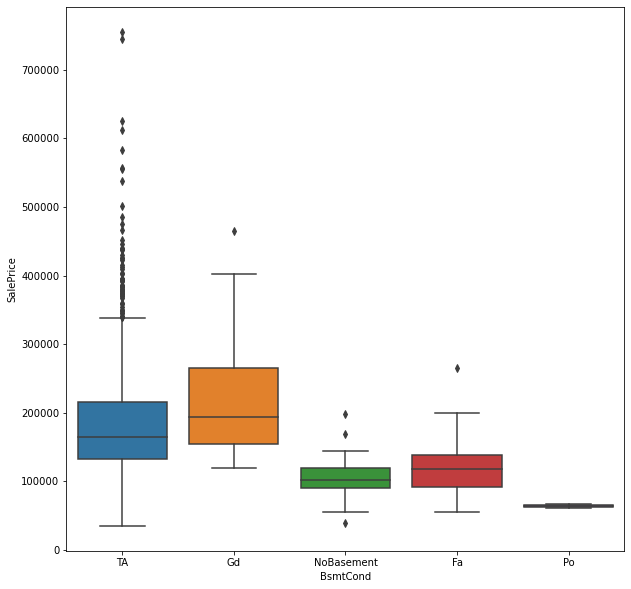

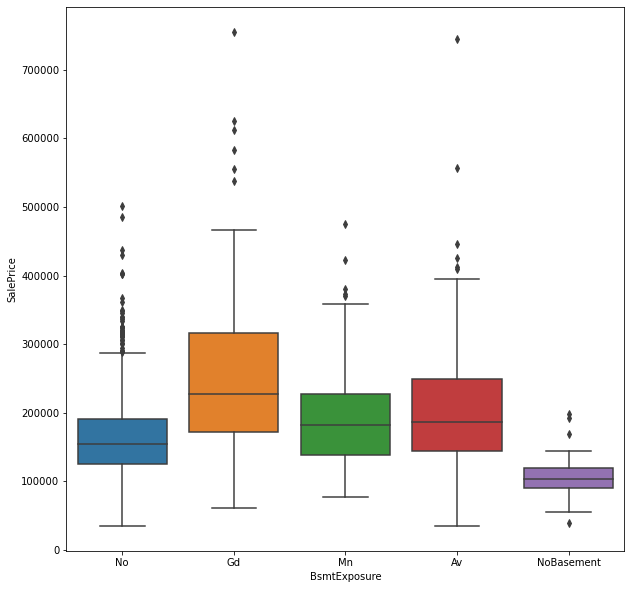

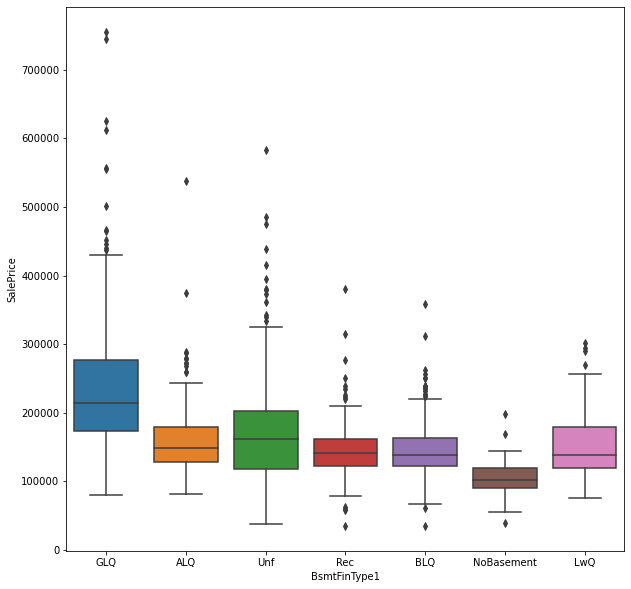

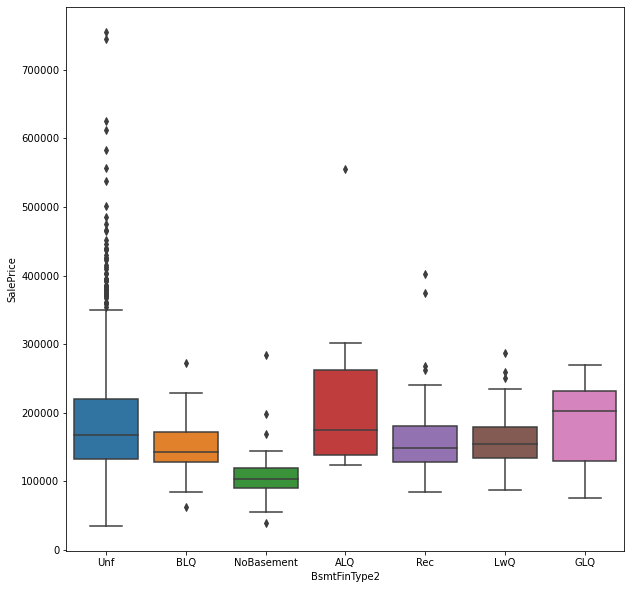

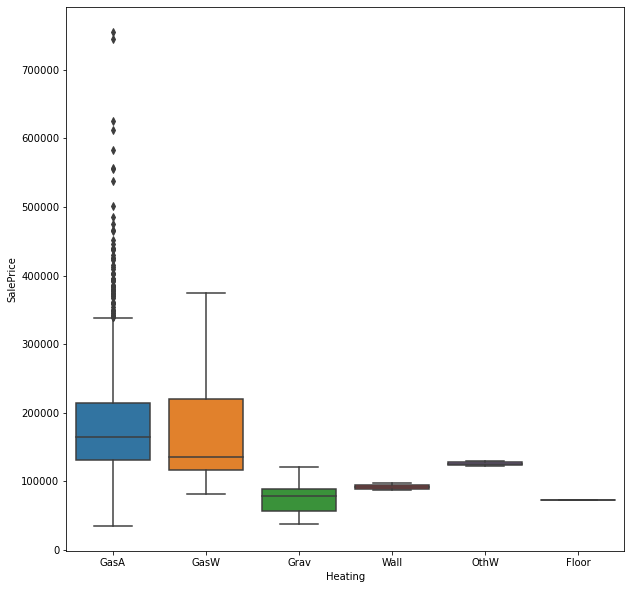

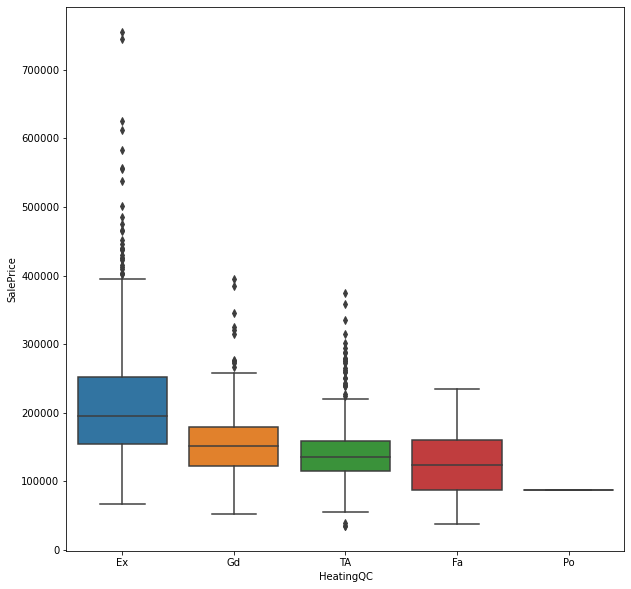

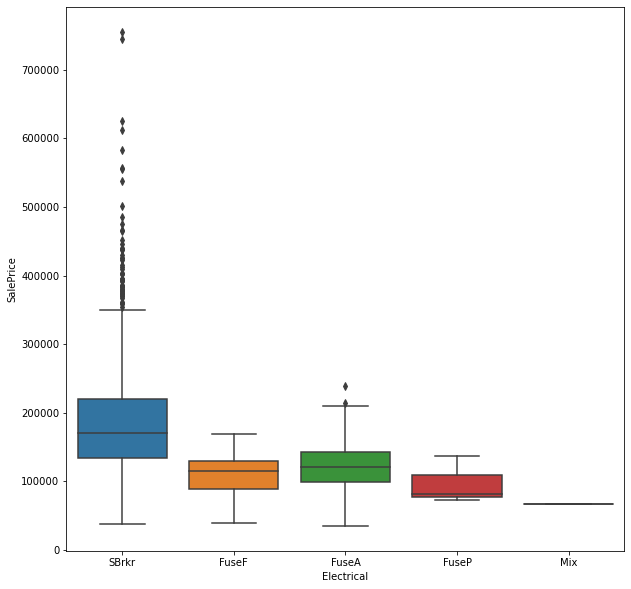

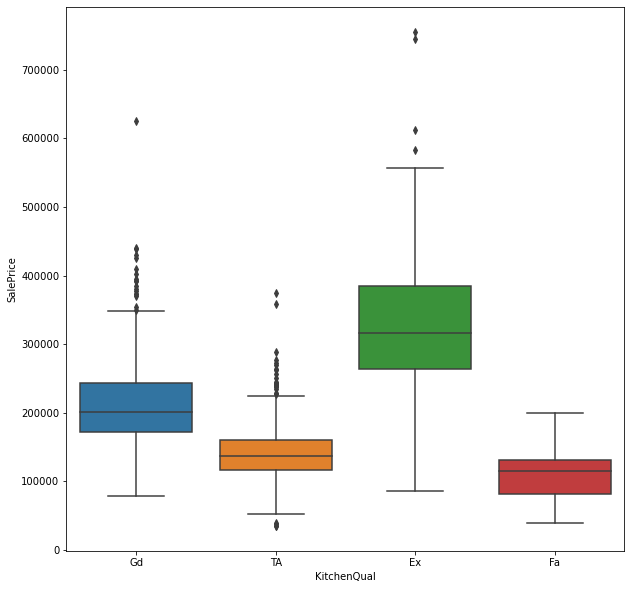

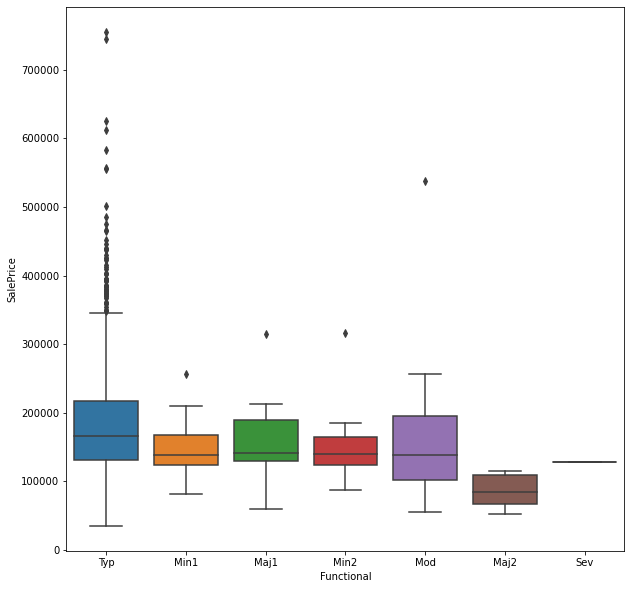

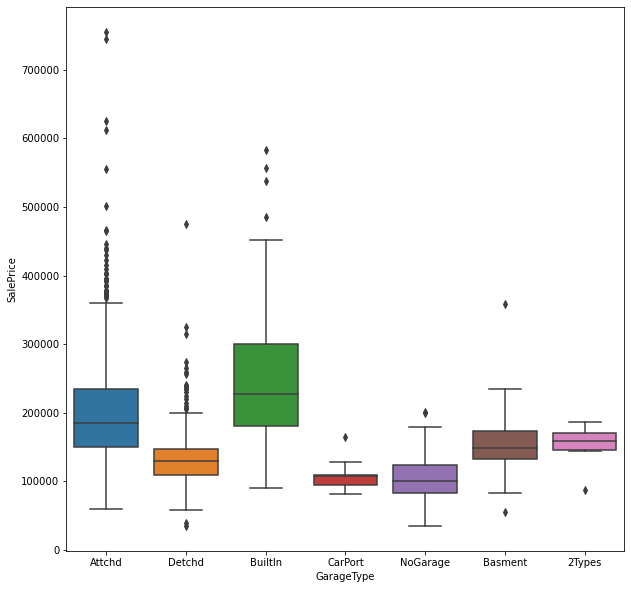

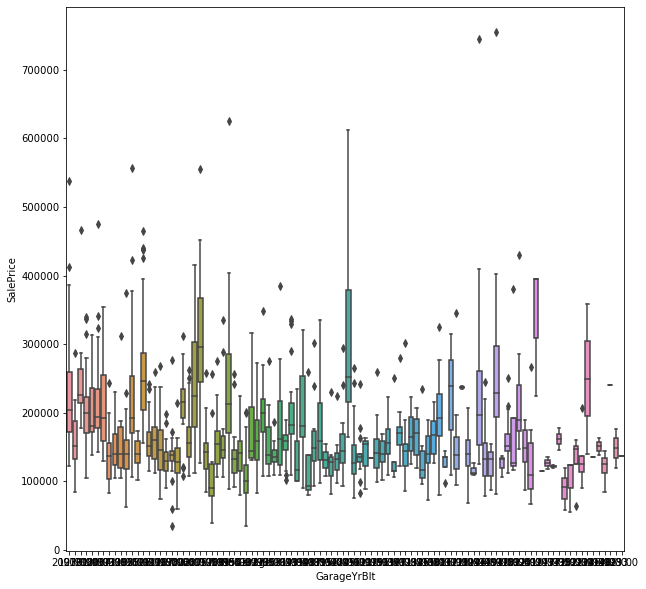

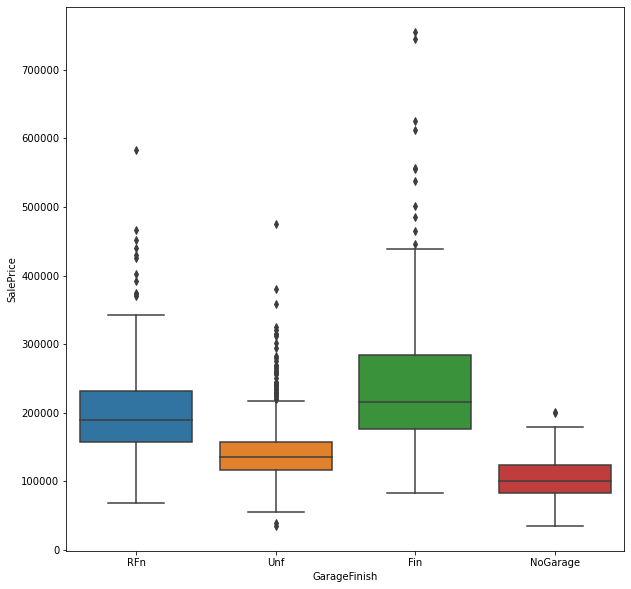

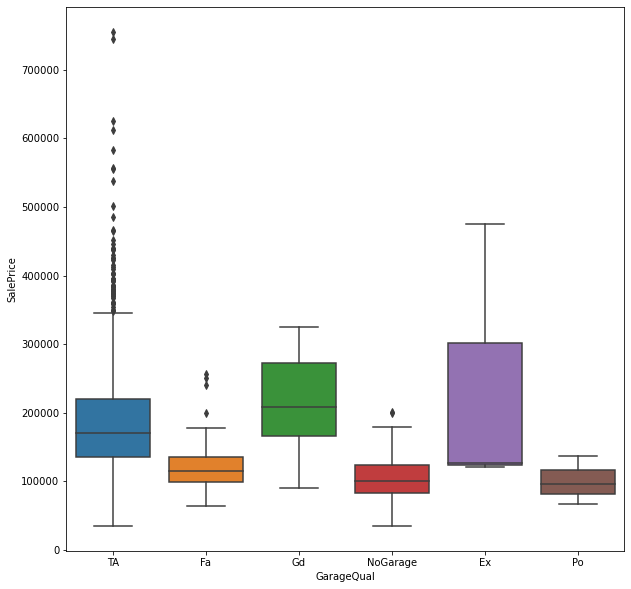

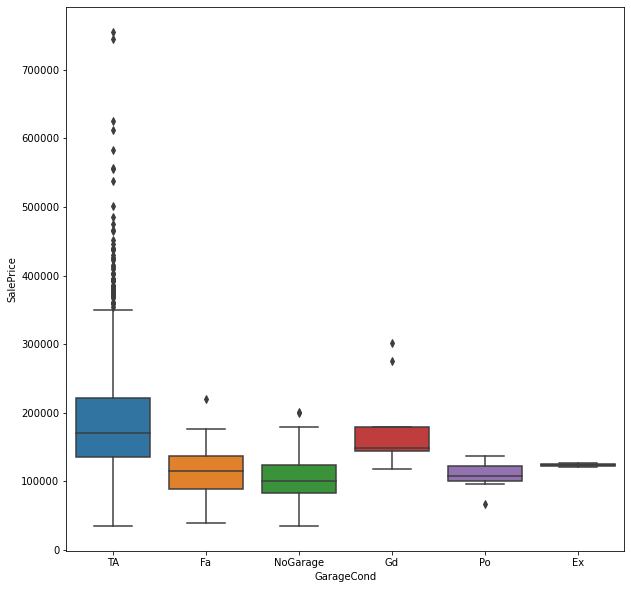

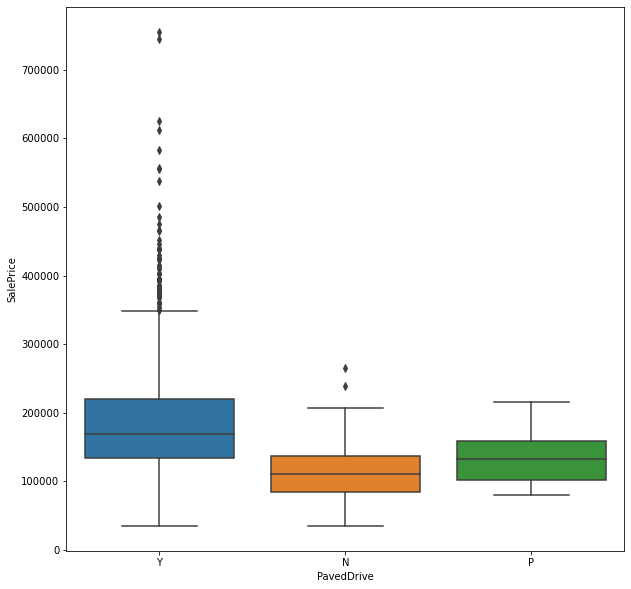

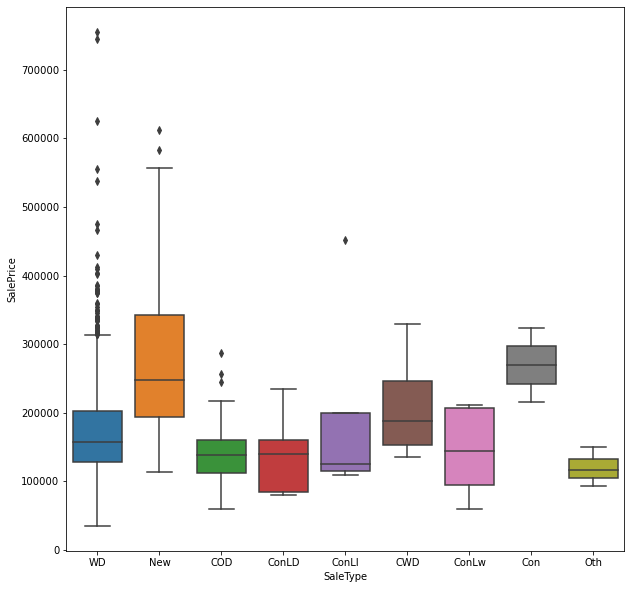

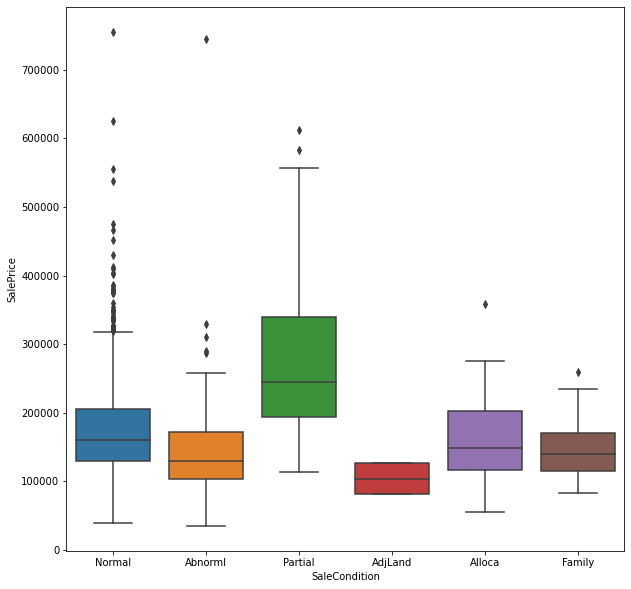

In [106]:
for i in range(len(cat_cols)):
    plt.figure(figsize = (10,10))
    sns.boxplot(x=cat_cols[i], y = 'SalePrice',data=df)
    plt.xlabel(cat_cols[i])
    plt.ylabel('SalePrice')
    plt.show()

#### Generating Dummy variables

In [107]:
df_cat_dummies = pd.get_dummies(df_categorical, drop_first=True)

In [108]:
df_cat_dummies.head()

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [109]:
# drop categorical variables 
df = df.drop(list(df_categorical.columns), axis=1)

In [110]:
# concat dummy variables with df
df = pd.concat([df, df_cat_dummies], axis=1)

In [111]:
df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706,0,150,...,0,0,0,0,1,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978,0,284,...,0,0,0,0,1,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486,0,434,...,0,0,0,0,1,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216,0,540,...,0,0,0,0,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655,0,490,...,0,0,0,0,1,0,0,0,1,0


In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 351 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(2), int64(34), uint8(315)
memory usage: 859.9 KB


#### Train - Test split

In [114]:
# train-test 70-30 split
df_train, df_test = train_test_split(df, 
                                     train_size = 0.7, 
                                     test_size = 0.3, 
                                     random_state = 100)

In [117]:
df_train[num_cols]

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
210,67.0,5604,5,6,1925,1950,0.0,468,0,396,...,0,0,96,0,0,0,0,4,2008,98000
318,90.0,9900,7,5,1993,1993,256.0,987,0,360,...,340,60,144,0,0,0,0,4,2009,260000
239,52.0,8741,6,4,1945,1950,0.0,94,0,641,...,0,140,0,0,0,0,0,4,2010,113000
986,59.0,5310,6,8,1910,2003,0.0,0,0,485,...,394,0,0,0,0,0,0,6,2006,117000
1416,60.0,11340,4,6,1885,1950,0.0,0,0,777,...,0,0,114,0,0,0,0,4,2010,122500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,60.0,6000,5,5,1926,1950,0.0,0,0,1008,...,0,0,138,0,0,0,0,6,2006,102000
802,63.0,8199,7,5,2005,2005,0.0,648,0,80,...,36,18,0,0,0,0,0,10,2008,189000
53,68.0,50271,9,5,1981,1987,0.0,1810,0,32,...,857,72,0,0,0,0,0,11,2006,385000
350,68.0,7820,9,5,2007,2007,362.0,0,0,1869,...,210,54,0,0,0,0,0,12,2007,318061


In [122]:
# rescale the features
scaler = MinMaxScaler()

In [123]:
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])
df_train[num_cols].head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
210,0.157534,0.019306,0.444444,0.625,0.384058,0.000000,0.00,0.082920,0.0,0.169521,...,0.000000,0.000000,0.173913,0.0,0.0,0.0,0.0,0.272727,0.50,0.087627
318,0.236301,0.039403,0.666667,0.500,0.876812,0.716667,0.16,0.174876,0.0,0.154110,...,0.396733,0.114723,0.260870,0.0,0.0,0.0,0.0,0.272727,0.75,0.312595
239,0.106164,0.033981,0.555556,0.375,0.528986,0.000000,0.00,0.016655,0.0,0.274401,...,0.000000,0.267686,0.000000,0.0,0.0,0.0,0.0,0.272727,1.00,0.108457
986,0.130137,0.017931,0.555556,0.875,0.275362,0.883333,0.00,0.000000,0.0,0.207620,...,0.459743,0.000000,0.000000,0.0,0.0,0.0,0.0,0.454545,0.00,0.114012
1416,0.133562,0.046139,0.333333,0.625,0.094203,0.000000,0.00,0.000000,0.0,0.332620,...,0.000000,0.000000,0.206522,0.0,0.0,0.0,0.0,0.272727,1.00,0.121650


In [124]:
# apply rescaling to the test set also
df_test[num_cols] = scaler.fit_transform(df_test[num_cols])
df_test[num_cols].head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
1436,0.133562,0.048827,0.333333,0.571429,0.716418,0.350000,0.00000,0.281536,0.0,0.128165,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.363636,0.25,0.143963
57,0.232877,0.065599,0.666667,0.428571,0.962687,0.900000,0.00000,0.000000,0.0,0.444444,...,0.000000,0.127971,0.0,0.0,0.0,0.000000,0.0,0.636364,0.00,0.276424
780,0.143836,0.041693,0.666667,0.428571,0.895522,0.766667,0.04126,0.000000,0.0,0.639276,...,0.302198,0.038391,0.0,0.0,0.0,0.000000,0.0,0.454545,0.25,0.240694
382,0.198630,0.050380,0.666667,0.428571,0.977612,0.933333,0.00000,0.000000,0.0,0.485271,...,0.197802,0.096892,0.0,0.0,0.0,0.000000,0.0,0.272727,0.25,0.306053
1170,0.188356,0.054407,0.555556,0.571429,0.761194,0.450000,0.00000,0.238574,0.0,0.296641,...,0.278846,0.000000,0.0,0.0,0.0,0.780488,0.0,0.545455,0.50,0.231980


In [125]:
# divide into X_train, y_train, X_test, y_test
y_train = df_train.pop('SalePrice')
X_train = df_train

y_test = df_test.pop('SalePrice')
X_test = df_test

### Ridge Regression

In [130]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'r2',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [131]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 9.0}


In [133]:
#Fitting Ridge model for alpha = 9 and printing coefficients which have been penalised
alpha = 9
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
coefficients = pd.Series(ridge.coef_, index=X_train.columns)

# Display results
print(f"Best alpha value: {alpha}")
print("Coefficients:")
print(coefficients)

Best alpha value: 9
Coefficients:
LotFrontage              0.000471
LotArea                  0.018380
OverallQual              0.070901
OverallCond              0.024847
YearBuilt                0.008346
                           ...   
SaleCondition_AdjLand    0.001307
SaleCondition_Alloca     0.004956
SaleCondition_Family    -0.004076
SaleCondition_Normal     0.002149
SaleCondition_Partial    0.005395
Length: 350, dtype: float64


In [134]:
sorted_coefficients = coefficients.abs().sort_values(ascending=False)
print(sorted_coefficients)

OverallQual             0.070901
2ndFlrSF                0.061087
GrLivArea               0.059882
Neighborhood_NoRidge    0.056414
1stFlrSF                0.043491
                          ...   
GarageYrBlt_1908.0      0.000000
ExterCond_Po            0.000000
Exterior2nd_Other       0.000000
GarageYrBlt_1932.0      0.000000
Electrical_Mix          0.000000
Length: 350, dtype: float64


In [159]:
# Set a threshold for considering coefficients as effectively zero
threshold = 0.001

# Count coefficients close to zero
zero_coefficients_count = np.sum(np.abs(ridge.coef_) < threshold)

# Display the count of coefficients close to zero
print(f"Number of coefficients close to zero: {zero_coefficients_count}")

Number of coefficients close to zero: 54


In [135]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8896262732951241
0.8485558202842456
1.3581518480555037
1.2967234931094498
0.0013302172850690535
0.0029605559203412096


### Lasso Regression

In [136]:
lasso = Lasso()

# cross validation
lmodel_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'r2', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

lmodel_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='r2', verbose=1)

In [137]:
# Printing the best hyperparameter alpha
print(lmodel_cv.best_params_)

{'alpha': 0.0001}


In [138]:
#Fitting Ridge model for alpha = 0.0001 and printing coefficients which have been penalised

alpha =0.0001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [151]:
lcoefficients = pd.Series(lasso.coef_, index=X_train.columns)
sorted_lcoefficients = lcoefficients.abs().sort_values(ascending=False)
print(sorted_lcoefficients)

GrLivArea               0.330647
Condition2_PosN         0.299837
OverallQual             0.123903
RoofMatl_WdShngl        0.122781
Neighborhood_NoRidge    0.060868
                          ...   
MSSubClass_80           0.000000
Electrical_FuseF        0.000000
Electrical_FuseP        0.000000
Electrical_Mix          0.000000
LotFrontage             0.000000
Length: 350, dtype: float64


In [160]:
# Set a threshold for considering coefficients as effectively zero
threshold = 0.001

# Count coefficients close to zero
zero_coefficients_count = np.sum(np.abs(lasso.coef_) < threshold)

# Display the count of coefficients close to zero
print(f"Number of coefficients close to zero: {zero_coefficients_count}")

Number of coefficients close to zero: 225


In [140]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.908010571709621
0.849336898944369
1.1319325328953345
1.290035596285355
0.0011086508647358809
0.002945286749509943


In [145]:
# Creating a table which contain all the metrics

Metrics = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)']
        }

reg_table = pd.DataFrame(Metrics)


In [146]:
rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([reg_table, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.889626,0.908011
1,R2 Score (Test),0.848556,0.849337
2,RSS (Train),1.358152,1.131933
3,RSS (Test),1.296723,1.290036
4,MSE (Train),0.036472,0.033296
5,MSE (Test),0.054411,0.054270


#### Doubling the optimal Ridge alpha value and fitting the model

In [149]:
alpha = 18
ridge_2 = Ridge(alpha=alpha)

ridge_2.fit(X_train, y_train)
r2coefficients = pd.Series(ridge_2.coef_, index=X_train.columns)
sorted_r2coefficients = r2coefficients.abs().sort_values(ascending=False)
print(sorted_coefficients)
print('-----------------')
print(sorted_r2coefficients)

OverallQual             0.070901
2ndFlrSF                0.061087
GrLivArea               0.059882
Neighborhood_NoRidge    0.056414
1stFlrSF                0.043491
                          ...   
GarageYrBlt_1908.0      0.000000
ExterCond_Po            0.000000
Exterior2nd_Other       0.000000
GarageYrBlt_1932.0      0.000000
Electrical_Mix          0.000000
Length: 350, dtype: float64
-----------------
OverallQual             0.057311
Neighborhood_NoRidge    0.049294
GrLivArea               0.046530
2ndFlrSF                0.044743
TotRmsAbvGrd            0.037903
                          ...   
Electrical_Mix          0.000000
Exterior2nd_Other       0.000000
ExterCond_Po            0.000000
GarageYrBlt_1932.0      0.000000
GarageYrBlt_1908.0      0.000000
Length: 350, dtype: float64


In [150]:
# Lets calculate r2 score with doubled alpha value
y_pred_train = ridge_2.predict(X_train)
y_pred_test = ridge_2.predict(X_test)

print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred_test))


0.8725676320307076
0.8291034155816768


#### Doubling the optimal Lasso alpha value and fitting the model

In [152]:
alpha =0.0002

lasso_2 = Lasso(alpha=alpha)
        
lasso_2.fit(X_train, y_train) 

Lasso(alpha=0.0002)

In [153]:
l2coefficients = pd.Series(lasso_2.coef_, index=X_train.columns)
sorted_l2coefficients = l2coefficients.abs().sort_values(ascending=False)
print(sorted_lcoefficients)
print('-----------------')
print(sorted_l2coefficients)

GrLivArea               0.330647
Condition2_PosN         0.299837
OverallQual             0.123903
RoofMatl_WdShngl        0.122781
Neighborhood_NoRidge    0.060868
                          ...   
MSSubClass_80           0.000000
Electrical_FuseF        0.000000
Electrical_FuseP        0.000000
Electrical_Mix          0.000000
LotFrontage             0.000000
Length: 350, dtype: float64
-----------------
GrLivArea               0.298882
Condition2_PosN         0.168211
OverallQual             0.137749
RoofMatl_WdShngl        0.080153
Neighborhood_NoRidge    0.066145
                          ...   
BsmtFinType1_Rec        0.000000
MSSubClass_70           0.000000
BsmtFinType2_BLQ        0.000000
BsmtFinType2_GLQ        0.000000
LotFrontage             0.000000
Length: 350, dtype: float64


In [154]:
# Lets calculate r2 score with doubled alpha value
y_pred_train = lasso_2.predict(X_train)
y_pred_test = lasso_2.predict(X_test)

print(r2_score(y_train, y_pred_train))
print(r2_score(y_test, y_pred_test))


0.8931522331480486
0.8496651323563453
